# U-net Model with fig-size 256*256

Import libraries

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


## Preprocssing

### Resizing

read images and resize them: size = (256, 256, 3)

In [2]:
def read_images_from_folder_and_resizing(img_folder_path, mask_folder_path):
    images = []
    masks  = []
    img_paths  = []
    mask_paths = []
    for image_name in sorted(os.listdir(img_folder_path)):
        image_path = os.path.join(img_folder_path, image_name)
        img_paths.append(image_path)

    for mask_name in sorted(os.listdir(mask_folder_path)):
        mask_path = os.path.join(mask_folder_path, mask_name)
        mask_paths.append(mask_path)

    for img_path, mask_path in zip(img_paths, mask_paths):
        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        desired_size = (256, 256)
        img  = cv2.resize(img, desired_size)
        mask = cv2.resize(mask, desired_size)

        images.append(img)
        masks.append(mask)
    return images, masks, img_paths, mask_paths



images_folder_path = 'Kvasir-SEG/images'
masks_folder_path  = 'Kvasir-SEG/masks'

images, masks, img_p, mask_p = read_images_from_folder_and_resizing(images_folder_path, masks_folder_path)
images = np.array(images)
masks  = np.array(masks)

### Normalizing

In [3]:
images = images / 255.
masks  = masks / 255.

print("Max pixel value (mask):", np.max(images))
print("Min pixel value (mask):", np.min(masks))

Max pixel value (mask): 1.0
Min pixel value (mask): 0.0


### Display an instance of normalized images and its mask

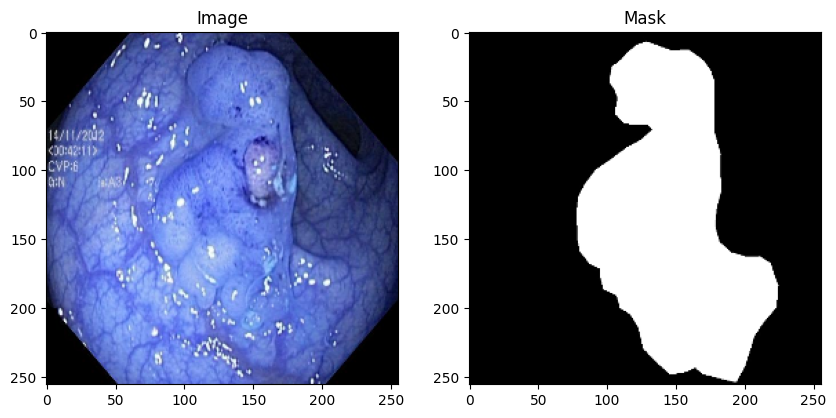

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(masks[2], cmap='gray')
plt.title('Mask')

plt.show()

### Spliting data into train, validation, and test.

In [5]:
def split_data(images, masks, split=0.1):
    total_size = len(images)
    test_size  = int(split * total_size)
    valid_size = int(split * total_size)

    X_train, X_valid = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_valid = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [6]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_data(images, masks)

print(f"train set size: {len(X_train)}\nvalid set size: {len(X_valid)}\ntest set size:  {len(X_test)}")

train set size: 800
valid set size: 100
test set size:  100


## Construct U-net model

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model


def Unet(input_shape):

    # Encode
    inputs = Input(input_shape)

    layer1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    # layer5 = Dropout(0.5)(layer1)
    layer1 = Conv2D(16, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(layer1)

    layer2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    # layer5 = Dropout(0.5)(layer2)
    layer2 = Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(layer2)

    layer3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    # layer5 = Dropout(0.3)(layer3)
    layer3 = Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(layer3)

    layer4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    # layer5 = Dropout(0.3)(layer4)
    layer4 = Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(layer4)

    # Buttleneck
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    layer5 = Dropout(0.3)(layer5)
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer5)


    # Decoder
    upsam1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer5)
    upsam1 = Concatenate()([upsam1, layer4])
    layer6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam1)

    upsam2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer6)
    upsam2 = Concatenate()([upsam2, layer3])
    layer7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam2)

    upsam3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer7)
    upsam3 = Concatenate()([upsam3, layer2])
    layer8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam3)

    upsam4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(layer8)
    upsam4 = Concatenate()([upsam4, layer1])
    layer9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam4)

    # Output
    layer10= Conv2D(1, (1, 1), activation='sigmoid')(layer9)

    model = Model(inputs=inputs, outputs=layer10)

    return model


In [8]:
model = Unet((256, 256, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │     448 │ input_layer[0][0]    │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │   2,320 │ conv2d[0][0]         │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │       0 │ conv2d_1[0][0]       │
│ (MaxPooling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │   4,640 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │   9,248 │ conv2d_2[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │       0 │ conv2d_3[0][0]       │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │  18,496 │ max_pooling2d_1[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │  36,928 │ conv2d_4[0][0]       │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │       0 │ conv2d_5[0][0]       │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  73,856 │ max_pooling2d_2[0][… │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │ 147,584 │ conv2d_6[0][0]       │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │       0 │ conv2d_7[0][0]       │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │ 295,168 │ max_pooling2d_3[0][… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │       0 │ conv2d_8[0][0]       │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │ 590,080 │ dropout[0][0]        │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │ 131,200 │ conv2d_9[0][0]     

 Total params: 1,745,025 (6.66 MB)

 Trainable params: 1,745,025 (6.66 MB)

 Non-trainable params: 0 (0.00 B)

### Define functions for metrics Dice and IoU

In [23]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)


def iou_coef(y_true, y_pred, smooth=100):
    y_true = K.expand_dims(y_true, axis=-1)
    
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    
    return iou


### Compile the model

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef, dice_coef])

### Fit the model with epochs=25 and batch_size=16

In [25]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=16)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8362 - dice_coef: 0.2350 - iou_coef: 0.1338 - loss: 0.3783 - val_accuracy: 0.8302 - val_dice_coef: 0.2264 - val_iou_coef: 0.1283 - val_loss: 0.3773
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8398 - dice_coef: 0.2451 - iou_coef: 0.1403 - loss: 0.3661 - val_accuracy: 0.8302 - val_dice_coef: 0.2352 - val_iou_coef: 0.1341 - val_loss: 0.3782
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8515 - dice_coef: 0.2233 - iou_coef: 0.1262 - loss: 0.3494 - val_accuracy: 0.8302 - val_dice_coef: 0.2610 - val_iou_coef: 0.1511 - val_loss: 0.3727
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8373 - dice_coef: 0.2786 - iou_coef: 0.1624 - loss: 0.3532 - val_accuracy: 0.8425 - val_dice_coef: 0.3214 - val_iou_coef: 0.1929 - val_loss: 0.3472
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8454 - dice_coef: 0.3160 - iou_coef: 0.1886 - loss: 0.3351 - val_accuracy: 0.8318 -

### Fit the model with epochs=25 and batch_size=32

In [26]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=32)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 210s 8s/step - accuracy: 0.8933 - dice_coef: 0.4850 - iou_coef: 0.3211 - loss: 0.2487 - val_accuracy: 0.8853 - val_dice_coef: 0.4948 - val_iou_coef: 0.3309 - val_loss: 0.2693
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.9031 - dice_coef: 0.5184 - iou_coef: 0.3509 - loss: 0.2279 - val_accuracy: 0.8885 - val_dice_coef: 0.4902 - val_iou_coef: 0.3271 - val_loss: 0.2651
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.9091 - dice_coef: 0.5498 - iou_coef: 0.3801 - loss: 0.2196 - val_accuracy: 0.8874 - val_dice_coef: 0.4848 - val_iou_coef: 0.3208 - val_loss: 0.2562
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9117 - dice_coef: 0.5627 - iou_coef: 0.3934 - loss: 0.2111 - val_accuracy: 0.8844 - val_dice_coef: 0.5745 - val_iou_coef: 0.4057 - val_loss: 0.2900
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.9080 - dice_coef: 0.5539 - iou_coef: 0.3868 - loss: 0.2211 - val_accuracy: 0.8936 -

### Evaluate the model on test set

In [39]:
loss, accuracy, iou, dice = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}\nTest Accuracy: {accuracy}\nIoU: {iou}\nDice: {dice}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8882 - dice_coef: 0.5114 - iou_coef: 0.3439 - loss: 0.2519
Test Loss: 0.24349582195281982
Test Accuracy: 0.8871749639511108
IoU: 0.5030017495155334
Dice: 0.3364679515361786


### Show the predictions

In [ ]:
predictions = model.predict(X_test)

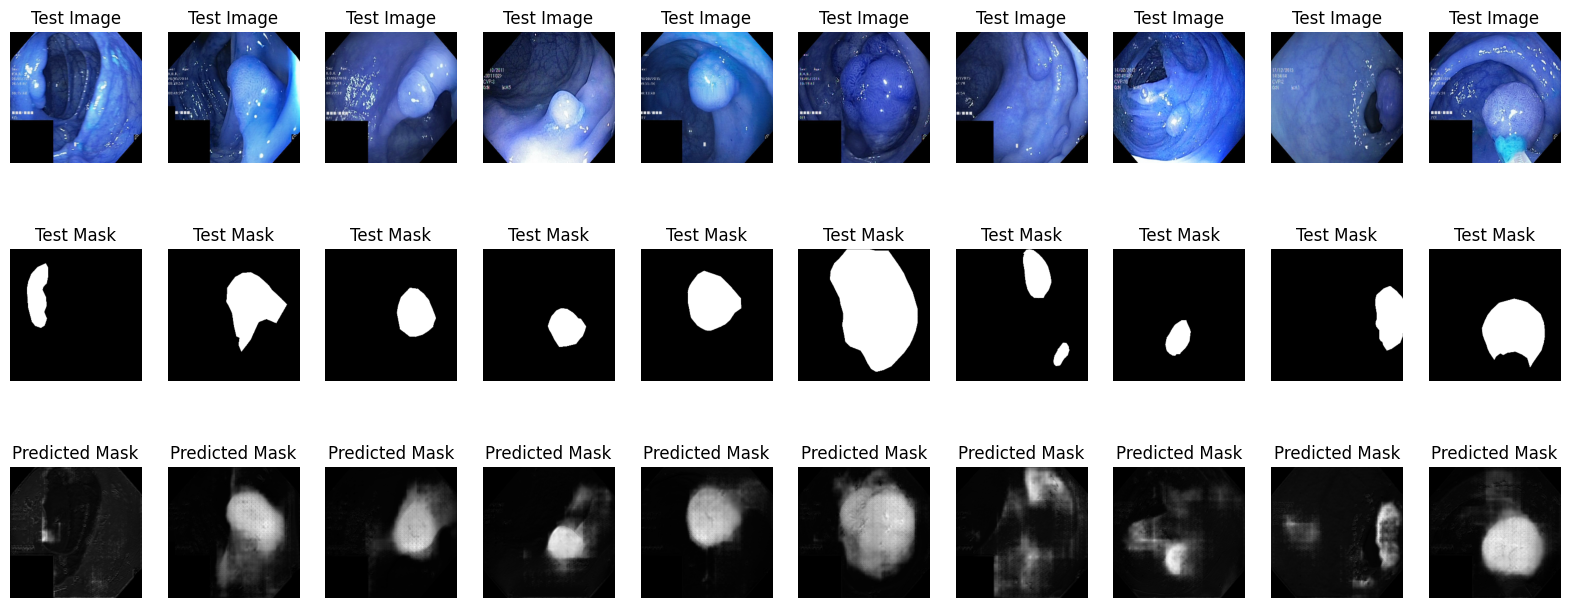

In [46]:
num_images = 10
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[i])
    plt.title('Test Image')
    plt.axis('off')
    
    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(y_test[i], cmap='gray')
    plt.title('Test Mask')
    plt.axis('off')
    
    plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(predictions[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.show()